In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kudata/Data/sample_submission.csv
/kaggle/input/kudata/Data/tile_meta.csv
/kaggle/input/kudata/Data/wsi_meta.csv
/kaggle/input/kudata/Data/polygons.jsonl
/kaggle/input/kudata/Data/coco_annotations_valid_class_1_folds5_fold1.json
/kaggle/input/kudata/Data/coco_annotations_train_class_1_folds5_fold1.json
/kaggle/input/kudata/Data/ultralytics/ultralytics/CONTRIBUTING.md
/kaggle/input/kudata/Data/ultralytics/ultralytics/.pre-commit-config.yaml
/kaggle/input/kudata/Data/ultralytics/ultralytics/setup.cfg
/kaggle/input/kudata/Data/ultralytics/ultralytics/LICENSE
/kaggle/input/kudata/Data/ultralytics/ultralytics/.gitignore
/kaggle/input/kudata/Data/ultralytics/ultralytics/README.zh-CN.md
/kaggle/input/kudata/Data/ultralytics/ultralytics/README.md
/kaggle/input/kudata/Data/ultralytics/ultralytics/MANIFEST.in
/kaggle/input/kudata/Data/ultralytics/ultralytics/requirements.txt
/kaggle/input/kudata/Data/ultralytics/ultralytics/CITATION.cff
/kaggle/input/kudata/Data/ultralytics/ultraly

# EDA

In [2]:
import os
import json
from PIL import Image
from collections import Counter

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import tifffile as tiff
import matplotlib.pyplot as plt

In [3]:
class CFG:
    img_path_template: str = "/kaggle/input/kudata/Data/train/{}.tif"

In [4]:
def get_cartesian_coords(coords, img_height):
    coords_array = np.array(coords).squeeze()
    xs = coords_array[:, 0]
    ys = -coords_array[:, 1] + img_height
    
    return xs, ys

In [5]:
def plot_annotated_image(image_dict, scale_factor: int = 1.0) -> None:
    array = tiff.imread(CFG.img_path_template.format(image_dict["id"]))
    img_example = Image.fromarray(array)
    annotations = image_dict["annotations"]
    
    # create figure
    fig = go.Figure()

    # constants
    img_width = img_example.size[0]
    img_height = img_example.size[1]
    

    # add invisible scatter trace
    fig.add_trace(
        go.Scatter(
            x=[0, img_width],
            y=[0, img_height],
            mode="markers",
            marker_opacity=0
        )
    )

    # configure axes
    fig.update_xaxes(
        visible=False,
        range=[0, img_width]
    )

    fig.update_yaxes(
        visible=False,
        range=[0, img_height],
        # the scaleanchor attribute ensures that the aspect ratio stays constant
        scaleanchor="x"
    )

    # add image
    fig.add_layout_image(dict(
        x=0,
        sizex=img_width,
        y=img_height,
        sizey=img_height,
        xref="x", yref="y",
        opacity=1.0,
        layer="below",
        sizing="stretch",
        source=img_example
    ))
    
    # add polygons
    for annotation in annotations:
        name = annotation["type"]
        xs, ys = get_cartesian_coords(annotation["coordinates"], img_height)
        fig.add_trace(go.Scatter(
            x=xs, y=ys, fill="toself",
            name=name,
            hovertemplate="%{name}",
            mode='lines'
        ))

    # configure other layout
    fig.update_layout(
        width=img_width * scale_factor,
        height=img_height * scale_factor,
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
        showlegend=False
    )

    # disable the autosize on double click because it adds unwanted margins around the image
    # and finally show figure
    fig.show(config={'doubleClick': 'reset'})

In [6]:
wsi_meta_df = pd.read_csv("/kaggle/input/kudata/Data/wsi_meta.csv")

In [7]:
sex_counts = wsi_meta_df.sex.value_counts()

fig = px.pie(values=sex_counts.values, names=sex_counts.index)
fig.update_traces(textposition='inside', textfont_size=14)
fig.update_layout(
    title={
        'text': "Pie distribution of sex values",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    legend_title_text='Aspect:'
)
fig.show()

In [8]:
race_counts = wsi_meta_df.race.value_counts()

fig = px.pie(values=race_counts.values, names=race_counts.index)
fig.update_traces(textposition='inside', textfont_size=14)
fig.update_layout(
    title={
        'text': "Pie distribution of race values",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    legend_title_text='Aspect:'
)
fig.show()

In [9]:
fig = px.violin(wsi_meta_df, x='race', y='age', box=True, color='sex', points="all")
fig.show()

In [10]:
fig = px.scatter(wsi_meta_df, x='height', y='weight', color='sex')
fig.show()

In [11]:
tile_meta_df = pd.read_csv("/kaggle/input/kudata/Data/tile_meta.csv")

In [12]:
print("Unique source WSIs --", list(np.unique(tile_meta_df.source_wsi)))
print("Number of unique source WSIs --", len(np.unique(tile_meta_df.source_wsi)))

Unique source WSIs -- [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Number of unique source WSIs -- 13


In [13]:
print("Unique datasets --", list(np.unique(tile_meta_df.dataset)))
print("Number of unique datasets --", len(np.unique(tile_meta_df.dataset)))

Unique datasets -- [1, 2, 3]
Number of unique datasets -- 3


In [14]:
swsi_count = Counter(tile_meta_df.source_wsi)

fig = px.bar(
    x=list(swsi_count.values()), y=list(swsi_count.keys()),
    color_discrete_sequence=['darkslateblue'],
    orientation='h', height=700
)
fig.update_layout(
    title={
        'text': "Source WSI Composition",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title="Frequency", yaxis_title="Source WSI"
)
fig.show()

In [15]:
with open('/kaggle/input/kudata/Data/polygons.jsonl', 'r') as json_file:
    json_list = list(json_file)
    
tiles_dicts = []
for json_str in json_list:
    tiles_dicts.append(json.loads(json_str))

In [16]:
print("Count of annotated tiles --", len(tiles_dicts))

Count of annotated tiles -- 1633


In [17]:
tiles_dicts[1000]["id"]

'9b9349a10d8d'

In [18]:
tile_meta_df[tile_meta_df.id == "9b9349a10d8d"]

id  source_wsi  dataset     i     j
4299  9b9349a10d8d           1        2  7680  5120

In [19]:
plot_annotated_image(tiles_dicts[1000])

In [20]:
plot_annotated_image(tiles_dicts[50])

In [21]:
tiles_dicts[2]["id"]
tile_meta_df[tile_meta_df.id == "0033bbc76b6b"]
plot_annotated_image(tiles_dicts[2])

In [22]:
tiles_dicts[500]["id"]
tile_meta_df[tile_meta_df.id == "4ca084aec87b"]
plot_annotated_image(tiles_dicts[500])

# MaskRCNN Pipeline

In [23]:
!git clone https://github.com/facebookresearch/detectron2.git

Cloning into 'detectron2'...
remote: Enumerating objects: 15188, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 15188 (delta 118), reused 118 (delta 69), pack-reused 14979
Receiving objects: 100% (15188/15188), 6.21 MiB | 17.02 MiB/s, done.
Resolving deltas: 100% (10980/10980), done.


In [24]:
%cd detectron2

/kaggle/working/detectron2


In [25]:
pip install -U .

Processing /kaggle/working/detectron2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 8.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 40.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 4.3 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=1255042 sha256=cb4241474311ecae7595d202a0fdae30a2d6558fb2e37005413e02ac0b051247
  Stored in directory: /tmp/pip-ephem-wheel-cache-jq9iqjny/wheels/40/14/52/84882755599a39f20a

In [26]:
pip wheel .

Processing /kaggle/working/detectron2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 34.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 76.6 MB/s eta 0:00:0000:0100:01
  Using cached pycocotools-2.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (426 kB)
  Using cached yacs-0.1.8-py3-none-any.whl (14 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 81.9 MB/s eta 0:00:00ta 0:00:01
  Using cached fvcore-0.1.5.post20221221-py3-none-any.whl
  Using cached iopath-0.1.9-py3-none-any.whl (27 kB)
  Using cached omegaconf-2.3.0-py3-none-any.whl (79 kB)
  Using cached hydra_core-1.3.2-py3-none-any.whl (154 kB)
  Using cached black-23.7.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.7 MB)
  Using cached packaging-23.1-py3-none-any.whl (48 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [27]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.7/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.7/index.html


In [28]:
import numpy as np
import pandas as pd
import os,random
import cv2
import json
import time
import torch
from tqdm.auto import tqdm

import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation.evaluator import DatasetEvaluator
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
setup_logger()



import pycocotools.mask as mask_util
from PIL import Image
import matplotlib.pyplot as plt
from fastcore.all import *
from pycocotools.coco import COCO
import matplotlib.patches as mpatches
from skimage import io

import warnings
warnings.filterwarnings('ignore') #Ignore "future" warnings and Data-Frame-Slicing warnings.

os.environ['CUDA_VISIBLE_DEVICES'] = '0' 
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print('GPU is available')
else:
    DEVICE = torch.device('cpu')
    print('CPU is used')
print('detectron ver:', detectron2.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning:

A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5



GPU is available
detectron ver: 0.6


In [29]:
Data_Resister_training="HuBMAP_train";
Data_Resister_valid="HuBMAP_valid";
from detectron2.data.datasets import register_coco_instances
dataDir=Path('/kaggle/input/kudata/Data/train/')

register_coco_instances(Data_Resister_training,{}, '/kaggle/input/kudata/Data/coco_annotations_valid_class_1_folds5_fold1.json', dataDir)
register_coco_instances(Data_Resister_valid,{},'/kaggle/input/kudata/Data/coco_annotations_train_class_1_folds5_fold1.json', dataDir)

metadata = MetadataCatalog.get(Data_Resister_training)
dataset_train = DatasetCatalog.get(Data_Resister_training)
dataset_valid = DatasetCatalog.get(Data_Resister_valid)

# /kaggle/input/kudata/Data/coco_annotations_valid_class_1_folds5_fold1.json
# /kaggle/input/kudata/Data/coco_annotations_train_class_1_folds5_fold1.json

[08/23 05:48:31 d2.data.datasets.coco]: Loaded 327 images in COCO format from /kaggle/input/kudata/Data/coco_annotations_valid_class_1_folds5_fold1.json
[08/23 05:48:32 d2.data.datasets.coco]: Loaded 1306 images in COCO format from /kaggle/input/kudata/Data/coco_annotations_train_class_1_folds5_fold1.json


loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


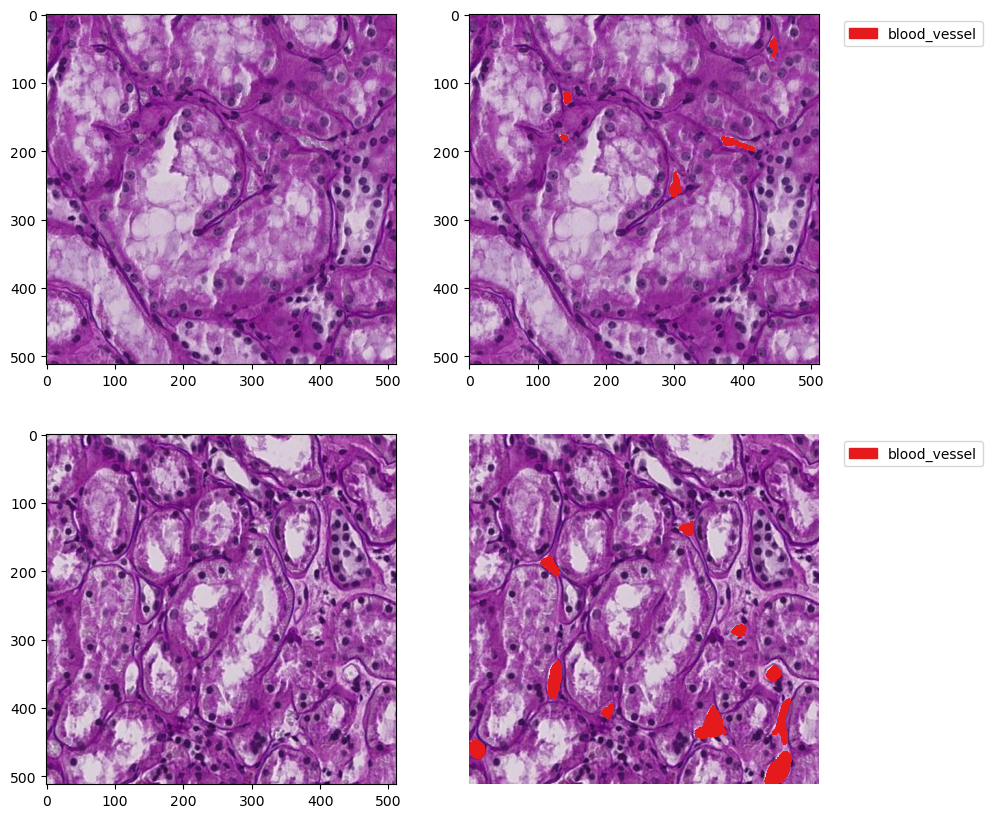

In [30]:
annFile = Path("/kaggle/input/kudata/Data/coco_annotations_valid_class_1_folds5_fold1.json")

colors = ['Set1'] 
legend = {1: 'blood_vessel'} 

coco = COCO(annFile)
imgIds = coco.getImgIds()
imgs = coco.loadImgs(imgIds[48:50])

fig, axs = plt.subplots(len(imgs), 2, figsize=(10, 5*len(imgs)))
for img, ax_row in zip(imgs, axs):
    ax = ax_row[0]  # Access the first axis in each row
    I = io.imread(dataDir / img["file_name"])
    annIds = coco.getAnnIds(imgIds=[img["id"]])
    anns = coco.loadAnns(annIds)
    ax.imshow(I)
    ax = ax_row[1]  # Access the second axis in each row
    ax.imshow(I)
    plt.sca(ax)
    for i, ann in enumerate(anns):
        category_id = ann['category_id']
        color = colors[category_id-1]
        #-----------------------------------------
        mask = coco.annToMask(ann)
        mask = np.ma.masked_where(mask == 0, mask)
        ax.imshow(mask, cmap=color, alpha=1)
        #-----------------------------------------
        handles = []
        for category_id in legend:
            color = colors[category_id - 1]
            handles.append(mpatches.Patch(color=plt.colormaps.get_cmap(color)(0)))
        ax.legend(handles, legend.values(), bbox_to_anchor=(1.05, 1), loc='upper left')

plt.axis('off')
plt.show()

In [31]:
from detectron2.evaluation.evaluator import DatasetEvaluator
import pycocotools.mask as mask_util
def precision_at(threshold, iou):
    matches = iou > threshold
    matches = np.atleast_2d(matches)  # Convert to 2D array if necessary
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    return np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)

def score(pred, targ):
    pred_masks = pred['instances'].pred_masks.cpu().numpy()
    enc_preds = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
    enc_targs = list(map(lambda x:x['segmentation'], targ))
    ious = mask_util.iou(enc_preds, enc_targs, [0]*len(enc_targs))
    prec = []
    for t in np.arange(0.4, 1.0, 0.05):
        tp, fp, fn = precision_at(t, ious)
        p = tp / (tp + fp + fn)
        prec.append(p)
    return np.mean(prec)

class MAPIOUEvaluator(DatasetEvaluator):
    def __init__(self, dataset_name):
        dataset_dicts = DatasetCatalog.get(dataset_name)
        self.annotations_cache = {item['image_id']:item['annotations'] for item in dataset_dicts}
            
    def reset(self):
        self.scores = []

    def process(self, inputs, outputs):
        for inp, out in zip(inputs, outputs):
            if len(out['instances']) == 0:
                self.scores.append(0)    
            else:
                targ = self.annotations_cache[inp['image_id']]
                self.scores.append(score(out, targ))

    def evaluate(self):
        return {"MaP IoU": np.mean(self.scores)}

In [32]:
from detectron2.engine import BestCheckpointer
from detectron2.checkpoint import DetectionCheckpointer

class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return MAPIOUEvaluator(dataset_name)
    def build_hooks(self):
        cfg = self.cfg.clone()
        hooks = super().build_hooks()
        checkpointer = DetectionCheckpointer(
            self.model,
            cfg.OUTPUT_DIR,
        )
        hooks.insert(-1, BestCheckpointer(cfg.TEST.EVAL_PERIOD, 
                                         checkpointer,
                                         "MaP IoU",
                                         "max",
                                         ))
        return hooks

In [33]:
cfg = get_cfg()
#config_name = "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml" 
config_name = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml" 
cfg.merge_from_file(model_zoo.get_config_file(config_name))

cfg.DATASETS.TRAIN = (Data_Resister_training,)
cfg.DATASETS.TEST = (Data_Resister_valid,)

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 # 1+ background class.
cfg.SOLVER.IMS_PER_BATCH = 2 
cfg.INPUT.MASK_FORMAT='bitmask'

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.SOLVER.MAX_ITER = 2000 #Maximum of iterations 1
cfg.SOLVER.BASE_LR = 0.0005 #(quite high base learning rate but should drop)
cfg.SOLVER.GAMMA = 0.9 #LR will be decreased by a factor of 0.9
cfg.SOLVER.WARMUP_ITERS = 300 #How many iterations to go from 0 to reach base LR
cfg.SOLVER.STEPS = (400,800,1200,1600) #At which point to change the LR 
cfg.TEST.EVAL_PERIOD = 250
#cfg.SOLVER.CHECKPOINT_PERIOD=250
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


trainer = Trainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[08/23 05:49:51 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:01, 115MB/s]                             


[08/23 05:49:53 d2.engine.train_loop]: Starting training from iteration 0
[08/23 05:50:16 d2.utils.events]:  eta: 0:10:58  iter: 19  total_loss: 3.423  loss_cls: 1.039  loss_box_reg: 0.2897  loss_mask: 0.6907  loss_rpn_cls: 1.404  loss_rpn_loc: 0.08927    time: 0.3404  last_time: 0.3718  data_time: 0.0311  last_data_time: 0.0111   lr: 3.2135e-05  max_mem: 1854M
[08/23 05:50:39 d2.utils.events]:  eta: 0:11:05  iter: 39  total_loss: 2.496  loss_cls: 0.7335  loss_box_reg: 0.4248  loss_mask: 0.674  loss_rpn_cls: 0.4751  loss_rpn_loc: 0.1065    time: 0.4232  last_time: 0.3365  data_time: 0.0115  last_data_time: 0.0113   lr: 6.5435e-05  max_mem: 1854M
[08/23 05:50:46 d2.utils.events]:  eta: 0:10:45  iter: 59  total_loss: 1.99  loss_cls: 0.5442  loss_box_reg: 0.4898  loss_mask: 0.6363  loss_rpn_cls: 0.2461  loss_rpn_loc: 0.0698    time: 0.3913  last_time: 0.3123  data_time: 0.0109  last_data_time: 0.0088   lr: 9.8735e-05  max_mem: 1854M
[08/23 05:50:53 d2.utils.events]:  eta: 0:10:37  iter: 7

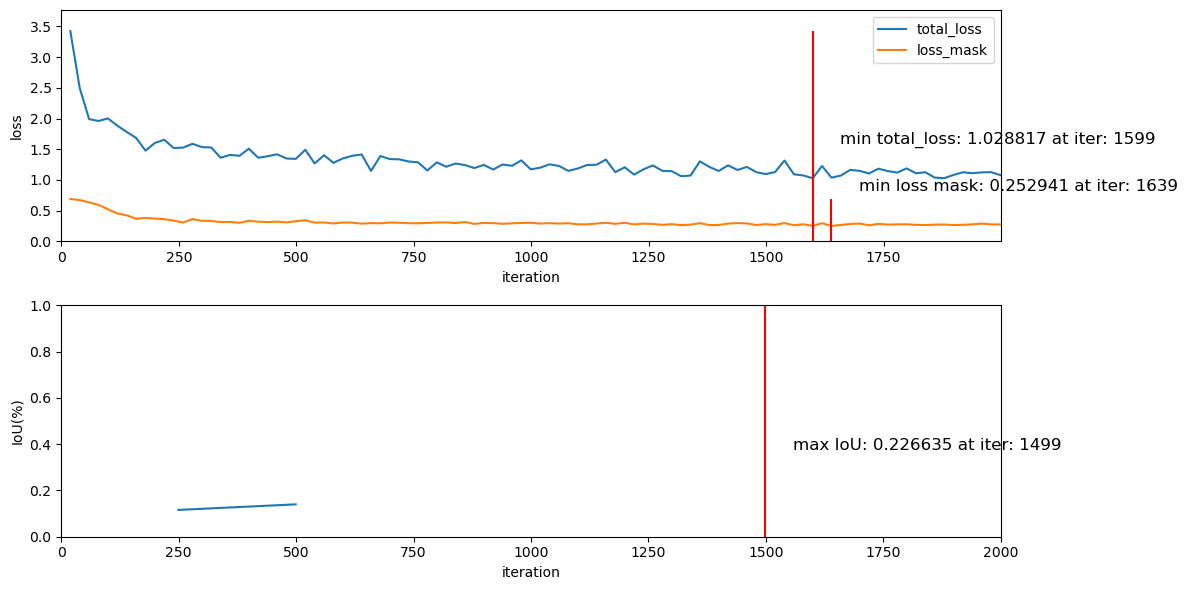

In [34]:
def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr('./output/metrics.json')
iters_total_loss = [x['iteration'] for x in experiment_metrics if 'total_loss' in x]
total_loss = [x['total_loss'] for x in experiment_metrics if 'total_loss' in x]

iters_loss_mask = [x['iteration'] for x in experiment_metrics if 'loss_mask' in x]
loss_mask = [x['loss_mask'] for x in experiment_metrics if 'loss_mask' in x]

iters_IoU = [x['iteration'] for x in experiment_metrics if 'MaP IoU' in x]
IoU = [x['MaP IoU'] for x in experiment_metrics if 'MaP IoU' in x]

fig, ax = plt.subplots(2,1,figsize=(12,6))
ax[0].plot(iters_total_loss, total_loss)
ax[0].plot(iters_loss_mask, loss_mask)
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('loss')
ax[0].legend(['total_loss', 'loss_mask'], loc='best')

iter = loss_mask.index(min(loss_mask))
ax[0].vlines(iters_loss_mask[iter], 0, float(max(loss_mask)),color="red")
ax[0].annotate('min loss mask: %f at iter: %d'%(float(min(loss_mask)),int(iters_loss_mask[iter])),xy=(iters_loss_mask[iter],min(loss_mask)),xytext=(+20,+25),textcoords='offset points',fontsize=12) #arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=.2')

iter = total_loss.index(min(total_loss))
ax[0].vlines(iters_total_loss[iter], 0, float(max(total_loss)),color="red")
ax[0].annotate('min total_loss: %f at iter: %d'%(float(min(total_loss)),int(iters_total_loss[iter])),xy=(iters_total_loss[iter],min(total_loss)),xytext=(+20,+25),textcoords='offset points',fontsize=12) #arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=.2')

ax[0].set_xlim([0,max(max(iters_total_loss),max(iters_loss_mask))])
ax[0].set_ylim([0,max(1.1*max(total_loss),1.1*max(loss_mask))])

ax[1].plot(iters_IoU, IoU)
ax[1].set_xlabel('iteration')
ax[1].set_ylabel('IoU(%)')
iter = IoU.index(max(IoU))
ax[1].vlines(iters_IoU[iter], 0, 5+float(max(IoU)),color="red")
ax[1].annotate('max IoU: %f at iter: %d'%(float(max(IoU)),int(iters_IoU[iter])),xy=(iters_IoU[iter],max(IoU)),xytext=(+20,+25),textcoords='offset points',fontsize=12) #arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=.2')
ax[1].set_xlim([0,max(iters_IoU)])
ax[1].set_ylim([0,1])

plt.tight_layout()

[08/23 06:31:36 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_best.pth ...
[08/23 06:31:37 d2.data.datasets.coco]: Loaded 1306 images in COCO format from /kaggle/input/kudata/Data/coco_annotations_train_class_1_folds5_fold1.json


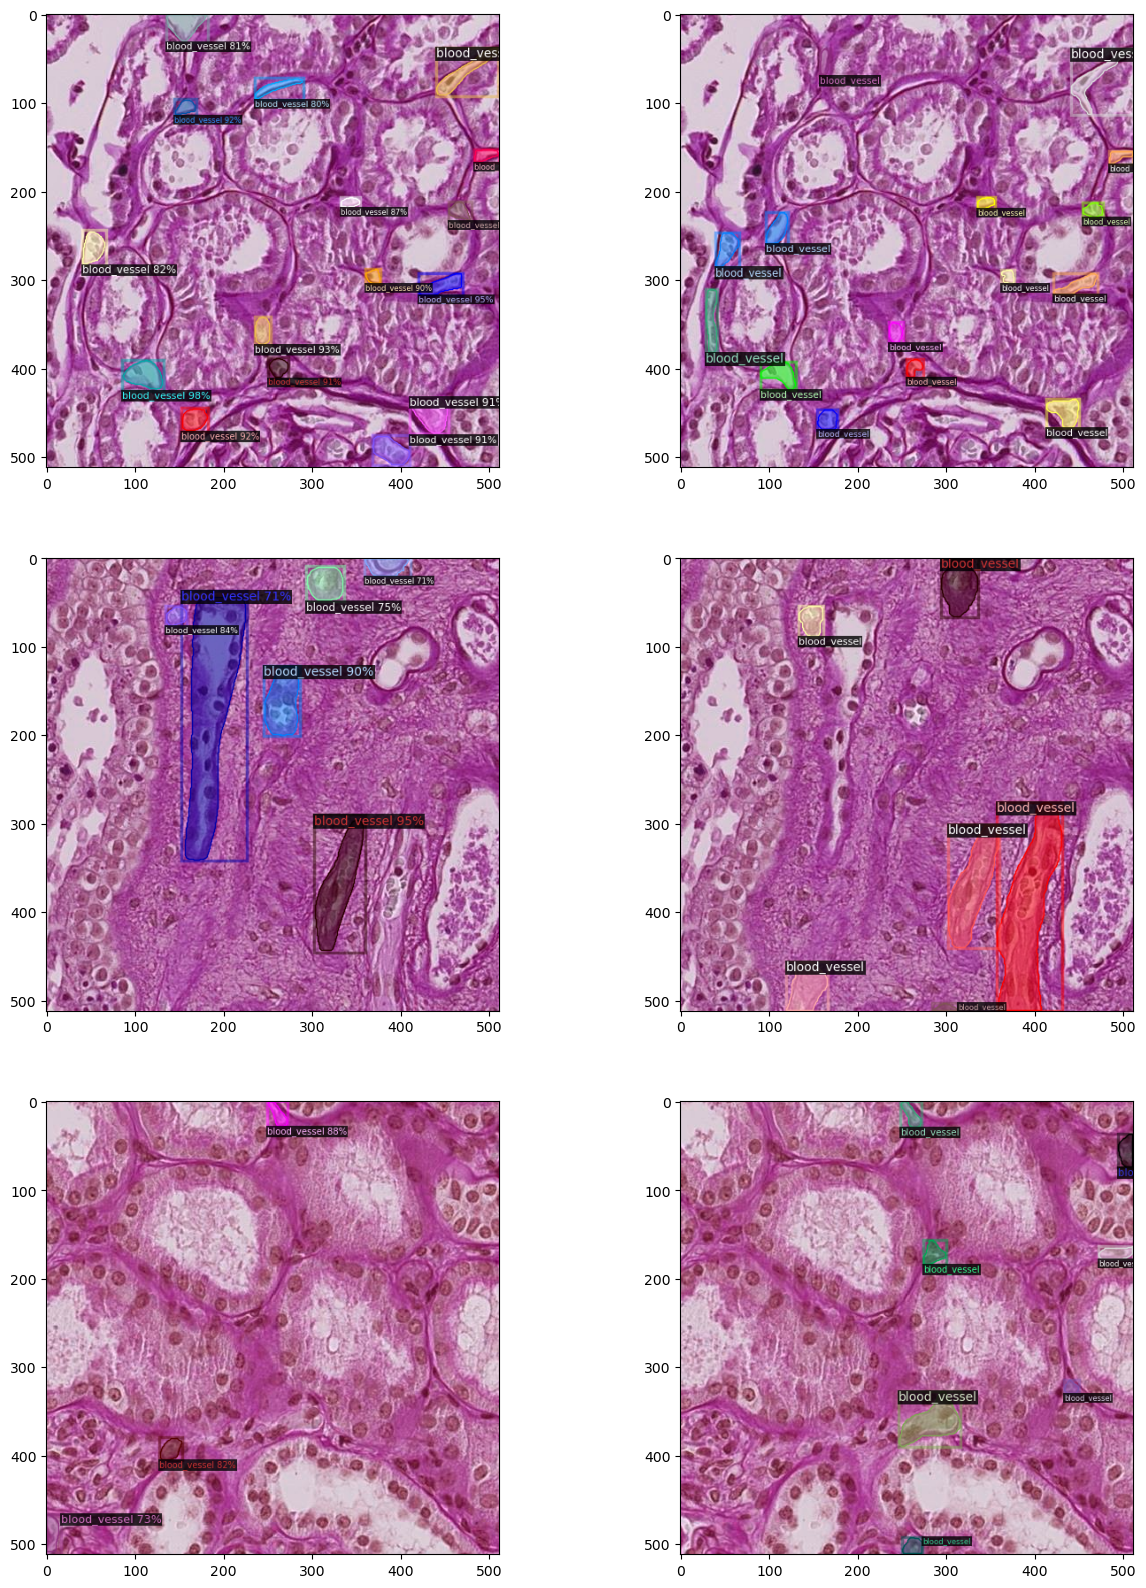

In [37]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_best.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)
dataset_dicts = DatasetCatalog.get(Data_Resister_valid)
outs = []
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata = MetadataCatalog.get(Data_Resister_training), 
                  # instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out_pred = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    visualizer = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get(Data_Resister_training))
    out_target = visualizer.draw_dataset_dict(d)
    outs.append(out_pred)
    outs.append(out_target)
_,axs = plt.subplots(len(outs)//2,2,figsize=(15,20))
for ax, out in zip(axs.reshape(-1), outs):
    ax.imshow(out.get_image()[:, :, ::-1])

# Generate Personal COCO Dataset

In [49]:
!pip install pycocotools -Uqq

In [51]:
import json, cv2, numpy as np, itertools, random, pandas as pd
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
from skimage import io
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
from sklearn import model_selection

import matplotlib.pyplot as plt
from skimage import io
from pycocotools.coco import COCO
import matplotlib.patches as mpatches

In [52]:
def coordinates_to_masks(coordinates, shape):
    masks = []
    for coord in coordinates:
        mask = np.zeros(shape, dtype=np.uint8)
        cv2.fillPoly(mask, [np.array(coord)], 1)
        masks.append(mask)
    return masks

def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(itertools.groupby(binary_mask.ravel(order='F'))):
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    return rle

def rle_to_binary_mask(mask_rle, shape=(512, 512)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) 
                       for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    return img.reshape(shape)

In [53]:
df = pd.read_csv('/kaggle/input/kudata/Data/tile_meta.csv')
df = df.query('dataset != 3')
#df=df.head(500)
df.reset_index(inplace=True,drop=True)
df.head()

id  source_wsi  dataset      i      j
0  0006ff2aa7cd           2        2  16896  16420
1  00168d1b7522           2        2  14848  14884
2  0033bbc76b6b           1        1  10240  43008
3  003504460b3a           3        2   8192  11776
4  004daf1cbe75           3        2   6144  11264

In [54]:
from sklearn.model_selection import StratifiedKFold

n_splits=5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (_, val_idx) in enumerate(skf.split(X=df, y=df['source_wsi']), 1):
    df.loc[val_idx, 'fold'] = fold
    
df['fold'] = df['fold'].astype(np.uint8)
df.groupby('fold').size()

fold
1    327
2    327
3    327
4    326
5    326
dtype: int64

In [55]:
selected_fold=1
train_ids = df.query(f'fold != {selected_fold}')['id'].values.tolist()
valid_ids = df.query(f'fold == {selected_fold}')['id'].values.tolist()
print(len(train_ids), len(valid_ids))

1306 327


In [56]:
jsonl_file_path = "/kaggle/input/kudata/Data/polygons.jsonl"
data = []
with open(jsonl_file_path, "r") as file:
    for line in file:
        data.append(json.loads(line))

In [57]:
categories_list=['blood_vessel','glomerulus']
categories_ids = {name:id+1 for id, name in enumerate(categories_list)}  
ids_categories = {id+1:name for id, name in enumerate(categories_list)}  
categories =[{'id':id,'name':name} for name,id in categories_ids.items()]

print(categories_ids)
print(ids_categories)
print(categories)

{'blood_vessel': 1, 'glomerulus': 2}
{1: 'blood_vessel', 2: 'glomerulus'}
[{'id': 1, 'name': 'blood_vessel'}, {'id': 2, 'name': 'glomerulus'}]


In [58]:
def coco_structure(images_ids):
    idx=1
    annotations=[]
    images=[]
    for item in tqdm(data,total=int(len(images_ids))):
        image_id=item["id"]
        if image_id in images_ids:
            image = {"id": image_id, "file_name": image_id + ".tif", "height": 512, "width": 512}
            images.append(image)
        else:continue
        #-----------------------------
        anns=item["annotations"]
        for an in anns:
            category_type=an["type"]
            if category_type !="unsure":
                category_id=categories_ids[category_type]
                segmentation=an["coordinates"]
                mask_img = coordinates_to_masks(segmentation, (512, 512))[0]
                ys, xs = np.where(mask_img)
                x1, x2 = min(xs), max(xs)
                y1, y2 = min(ys), max(ys)

                rle = binary_mask_to_rle(mask_img)

                seg = {
                    "id": idx,
                    "image_id": image_id,
                    "category_id": category_id,
                    "segmentation": rle,
                    "bbox": [int(x1), int(y1), int(x2 - x1 + 1), int(y2 - y1 + 1)],
                    "area": int(np.sum(mask_img)),
                    "iscrowd": 0,
                }
                if image_id in images_ids:
                    annotations.append(seg)
                    idx=idx+1
                
    return {"info": {}, "licenses": [], "categories": categories, "images": images, "annotations": annotations}

In [59]:
train_coco_data = coco_structure(train_ids)
valid_coco_data = coco_structure(valid_ids)

  0%|          | 0/1306 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

In [61]:
output_file_path = f"coco_annotations_train_all_fold{selected_fold}.json"
with open(output_file_path, "w", encoding="utf-8") as output_file:
    json.dump(train_coco_data, output_file, ensure_ascii=True, indent=4)
    
output_file_path = f"coco_annotations_valid_all_fold{selected_fold}.json"
with open(output_file_path, "w", encoding="utf-8") as output_file:
    json.dump(valid_coco_data, output_file, ensure_ascii=True, indent=4)

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


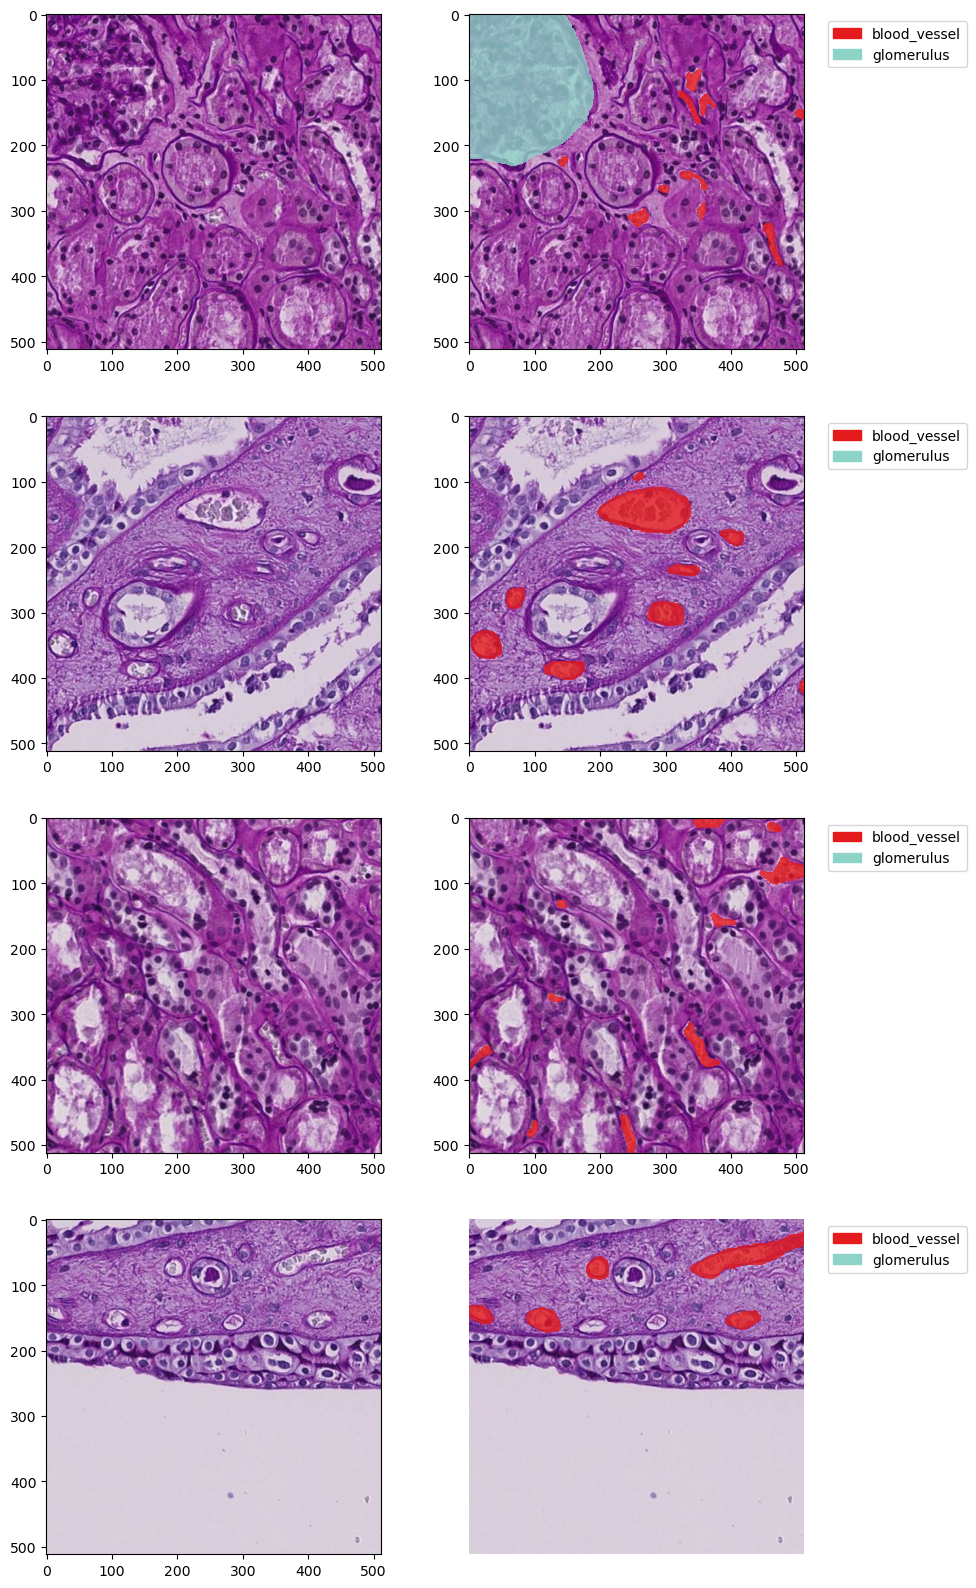

In [62]:
dataDir = Path("/kaggle/input/kudata/Data/train")
annFile = Path(f"./coco_annotations_valid_all_fold{selected_fold}.json")

colors = ['Set1','Set3'] 
legend = ids_categories #{1: 'blood_vessel',2:glomerulus}

coco = COCO(annFile)
imgIds = coco.getImgIds()
imgs = coco.loadImgs(imgIds[0:4])

fig, axs = plt.subplots(len(imgs), 2, figsize=(10, 5*len(imgs)))
for img, ax_row in zip(imgs, axs):
    ax = ax_row[0]  # Access the first axis in each row
    I = io.imread(dataDir / img["file_name"])
    annIds = coco.getAnnIds(imgIds=[img["id"]])
    anns = coco.loadAnns(annIds)
    ax.imshow(I)
    ax = ax_row[1]  # Access the second axis in each row
    ax.imshow(I)
    plt.sca(ax)
    for i, ann in enumerate(anns):
        category_id = ann['category_id']
        color = colors[category_id-1]
        #-----------------------------------------
        mask = coco.annToMask(ann)
        mask = np.ma.masked_where(mask == 0, mask)
        ax.imshow(mask, cmap=color, alpha=0.8)
        #-----------------------------------------
        handles = []
        for category_id in legend:
            color = colors[category_id - 1]
            handles.append(mpatches.Patch(color=plt.colormaps.get_cmap(color)(0)))
        ax.legend(handles, legend.values(), bbox_to_anchor=(1.05, 1), loc='upper left')

plt.axis('off')
plt.show()